In [1]:
from typing import TypeVar, Generic, Dict, List, Optional, Iterable
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import networkx as nx

V = TypeVar("V")
D = TypeVar("D")

In [2]:
class Constraint(Generic[V, D], ABC):
    """
    Abstract Base Class for all constraints
    """
    variables: Iterable[V]

    def __init__(self, variables: Iterable[V]):
        self.variables = variables

    @abstractmethod
    def is_satisfied_with(self, assignment: Dict[V, D]) -> bool:
        pass


In [3]:
class ConstraintSatisfactionProblem(Generic[V, D]):
    variables: List[V]
    domains: Dict[V, List[D]]
    constraints: Dict[V, List[Constraint[V, D]]]

    def __init__(self):
        self.variables = list()
        self.domains = dict()
        self.constraints = dict()

    def add_variable(self, var: V, domain: List[D]) -> 'CSP':
        self.variables.append(var)
        self.domains[var] = domain
        self.constraints[var] = list()
        return self

    def add_constraint(self, constraint: Constraint[V, D]) -> 'CSP':
        for var in constraint.variables:
            if var not in self.variables:
                raise LookupError(f"Unknown variable {var} specified in constraint")
            self.constraints[var].append(constraint)
        return self

    def is_consistent(self, var: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[var]:
            if not constraint.is_satisfied_with(assignment):
                return False
        return True

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        if len(assignment) == len(self.variables):
            return assignment

        unassigned_vars: List[V] = [var for var in self.variables if var not in assignment]
        most_constrained_var = max(unassigned_vars, key=lambda var: len(self.constraints[var]))

        for value in self.domains[most_constrained_var]:
            local_assignment = assignment.copy()
            local_assignment[most_constrained_var] = value

            if self.is_consistent(most_constrained_var, local_assignment):
                result = self.backtracking_search(local_assignment)
                if result is not None:
                    return result

        return None

In [4]:
class ZookeeperConstraint:

    class Rejects(Constraint[str, str]):

        def __init__(self, animal: str, neighbor_animal: str, reason: str = None):
            super().__init__([animal, neighbor_animal])
            self.animal1: str = animal
            self.animal2: str = neighbor_animal
            self.reason: str = reason

        def is_satisfied_with(self, assignment: Dict[str, int]) -> bool:
            """
            Assignment carries the whole configuration of which animals are assigned to which cage
            Meaning: if animal2 IS NOT in it, the assignment is free for animal1 to use, and vice-versa
            Otherwise, if both are in it, the constraint is satisfied
            AS LONG AS animal1 and animal2 are NOT in the same
            """
            if self.animal1 not in assignment or self.animal2 not in assignment:
                return True

            return assignment[self.animal1] != assignment[self.animal2]

    class RejectsSameOrAdjacent(Constraint[str, str]):

        def __init__(self, animal: str, another_animal: str, reason: str = None):
            super().__init__([animal, another_animal])
            self.animal1 = animal
            self.animal2 = another_animal
            self.reason: str = reason

        def is_satisfied_with(self, assignment: Dict[str, int]) -> bool:
            """
            Assignment carries the whole configuration of which animals are assigned to which cage
            Meaning: if animal2 IS NOT in it, the assignment is free for animal1 to use, and vice-versa
            Otherwise, if both are in it, the constraint is satisfied:
            AS LONG AS animal1 and animal2 are NOT in the same or adjacent cages
            """

            if self.animal1 not in assignment or self.animal2 not in assignment:
                return True

            animal1_cage: int = assignment[self.animal1]
            animal2_cage: int = assignment[self.animal2]
            return abs(animal1_cage - animal2_cage) > 1

    class MustBeTogetherWith(Constraint[str, str]):

        def __init__(self, animal: str, neighbor_animal: str, reason: str = None):
            super().__init__([animal, neighbor_animal])
            self.animal1: str = animal
            self.animal2: str = neighbor_animal
            self.reason: str = reason

        def is_satisfied_with(self, assignment: Dict[str, str]) -> bool:
            """
            Assignment carries the whole configuration of which animals are assigned to which cage
            Meaning: if animal2 IS NOT in it, the assignment is free for animal1 to use, and vice-versa
            Otherwise, if both are in it, the constraint is satisfied:
            AS LONG AS animal1 and animal2 are BOTH in the SAME cage
            """
            if self.animal1 not in assignment or self.animal2 not in assignment:
                return True

            return assignment[self.animal1] == assignment[self.animal2]

    class MustBeInCageID(Constraint[str, int]):

        def __init__(self, animal: str, cage: int, reason: str = None):
            super().__init__([animal])
            self.animal: str = animal
            self.cage_number: int = cage
            self.reason: str = reason

        def is_satisfied_with(self, assignment: Dict[str, int]) -> bool:
            """
            Assignment carries the whole configuration of which animals are assigned to which cage
            Meaning: self.animal must have been assigned to specific self.cage
            for this Constraint to be accepted, otherwise Reject
            """
            return assignment[self.animal] == self.cage_number


In [5]:
def zookeeper() -> Optional[Dict[str, int]]:
    domain = [1, 2, 3, 4]
    problem = ConstraintSatisfactionProblem()\
        .add_variable(var="Leao", domain=domain)\
        .add_variable(var="Antilope", domain=domain) \
        .add_variable(var="Hiena", domain=domain) \
        .add_variable(var="Tigre", domain=domain) \
        .add_variable(var="Pavao", domain=domain) \
        .add_variable(var="Suricate", domain=domain) \
        .add_variable(var="Javali", domain=domain)

    problem \
        .add_constraint(ZookeeperConstraint.Rejects("Leao", "Tigre", reason="Regra #1")) \
        .add_constraint(ZookeeperConstraint.MustBeTogetherWith("Suricate", "Javali", reason="Regra #2"))\
        .add_constraint(ZookeeperConstraint.Rejects("Hiena", "Leao", reason="Regra #3"))\
        .add_constraint(ZookeeperConstraint.Rejects("Hiena", "Antilope", reason="Regra #3")) \
        .add_constraint(ZookeeperConstraint.Rejects("Hiena", "Pavao", reason="Regra #3")) \
        .add_constraint(ZookeeperConstraint.Rejects("Hiena", "Suricate", reason="Regra #3")) \
        .add_constraint(ZookeeperConstraint.Rejects("Hiena", "Javali", reason="Regra #3")) \
        .add_constraint(ZookeeperConstraint.Rejects("Tigre", "Suricate", reason="Regra #4")) \
        .add_constraint(ZookeeperConstraint.Rejects("Tigre", "Javali",  reason="Regra #4")) \
        .add_constraint(ZookeeperConstraint.Rejects("Tigre", "Pavao",  reason="Regra #4")) \
        .add_constraint(ZookeeperConstraint.RejectsSameOrAdjacent("Antilope", "Leao", reason="Regra #5")) \
        .add_constraint(ZookeeperConstraint.RejectsSameOrAdjacent("Antilope", "Tigre", reason="Regra #5")) \
        .add_constraint(ZookeeperConstraint.Rejects("Pavao", "Leao", reason="Regra #6")) \
        .add_constraint(ZookeeperConstraint.MustBeInCageID("Leao", 1, reason="Regra #7"))


    return problem.backtracking_search()

In [6]:
def render_layout(result):
    g = nx.Graph()
    g.add_edge('Cage 1', 'Cage 2')
    g.add_edge('Cage 2', 'Cage 3')
    g.add_edge('Cage 3', 'Cage 4')
    [g.add_edge(key, f"Cage {value}") for key, value in result.items()]

    position = nx.kamada_kawai_layout(g)
    nx.draw_networkx_nodes(g, pos=position,
                           nodelist=['Cage 1', 'Cage 2', 'Cage 3', 'Cage 4'],
                           node_color='#999999',
                           node_size=1800)

    nx.draw_networkx_nodes(g, pos=position,
                           nodelist=list(result.keys()),
                           node_color='#444444',
                           node_size=1500)

    nx.draw_networkx_edges(g, pos=position,
                           edgelist=g.edges,
                           width=1,
                           alpha=0.5,
                           edge_color="black")

    nx.draw_networkx_labels(g, pos=position,
                            font_size=8,
                            font_family="sans-serif",
                            font_color="white")

    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['figure.dpi'] = 400
    plt.title("Zookeeper Animal Setup")
    plt.axis("off")
    plt.show()

In [7]:
result = zookeeper()

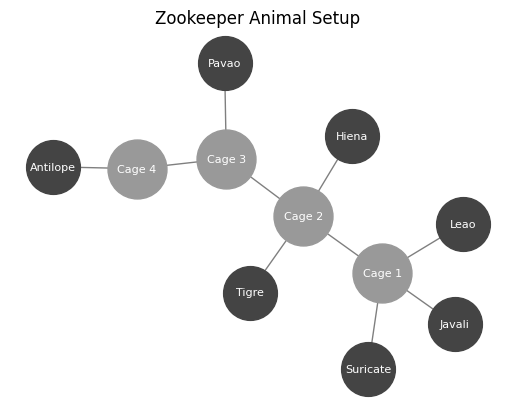

In [8]:
if result:
  render_layout(result)
else:
  print("There's no solution for the Problem with the current Constraints")